In [26]:
import torch
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import random
from IPython.display import clear_output

In [27]:
class ActorNet(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(ActorNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(128,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,64)
        self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,output_dim)
        
    def forward(self,obj,action=False,max_act=False):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        logits = self.fc4(x)
        m = Categorical(logits=logits)
        act = m.sample()
        log_p = m.log_prob(act)
        if action:
            return m.log_prob(torch.LongTensor(action))
        else:
            if max_act:
                return torch.argmax(logits).item()
            else:
                return m,act.item(),log_p

In [28]:
env = gym.make('SpaceInvaders-ram-v0')

In [29]:
input_dim = env.observation_space.shape[0]

In [30]:
output_dim = env.action_space.n

In [31]:
act_net = ActorNet(input_dim,output_dim)

In [32]:
class CriticNet(nn.Module):
    def __init__(self,input_dim):
        super(CriticNet,self).__init__()
        self.fc1 = nn.Linear(input_dim,128)
        self.elu1 = nn.Tanh()
        self.fc2 = nn.Linear(128,64)
        self.elu2 = nn.Tanh()
        self.fc3 = nn.Linear(64,64)
        self.elu3 = nn.Tanh()
        self.fc4 = nn.Linear(64,1)
        
    def forward(self,obj):
        x = torch.FloatTensor(obj)
        x = self.elu1(self.fc1(x))
        x = self.elu2(self.fc2(x))
        x = self.elu3(self.fc3(x))
        v = self.fc4(x)
        return v

In [33]:
crit_net = CriticNet(input_dim)

In [34]:
gamma = 0.99
lamda = 0.95
clip_ratio = 0.2
lr_pi = 1e-4
lr_v = 1e-3
target_kl = 0.01
train_pi_iter = 5
train_v_iter = 5

In [35]:
optim_actor = optim.Adam(params=act_net.parameters(),lr=lr_pi)
optim_critic = optim.Adam(params=crit_net.parameters(),lr=lr_v)

In [36]:
def disc_cuml_rew_calc(rews,gamma=gamma):
    return list(scipy.signal.lfilter([1], [1, float(-gamma)], rews[::-1], axis=0)[::-1])

730


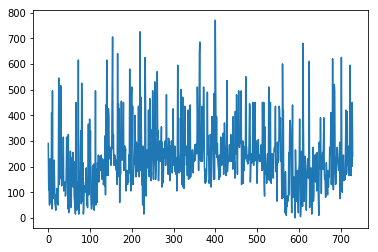

KeyboardInterrupt: 

In [37]:
traj_n = 1000
trajectories = []
rewards = []
for t in range(traj_n):
    traj = []
    rews = []
    obj = env.reset()
    done = False
    while not done:
        v = crit_net.forward(obj)
        m,act,log_p = act_net.forward(obj)
        next_obj,reward,done,_ = env.step(act)
        traj.append([act,obj,next_obj,reward,done,log_p,v])
        rews.append(reward)
        obj = next_obj
#         if t % 10 == 0:
#             env.render()
    if t % 100 == 0:
        print(t)
#         env.close()
    if t % 10 == 0:
        clear_output(wait=True)
        print(t)
        episode_returns = [sum(i) for i in rewards]
        plt.plot(episode_returns)
        plt.show()
        
    rews_disc_cuml_scaled = disc_cuml_rew_calc(rews)
    rewards.append(rews)
    traj = [i + [j] for i,j in zip(traj,rews_disc_cuml_scaled)]
#     trajectories.append(traj)
    act,obj,_,rews,_,old_policy,v,rews_disc_cuml = zip(*traj)
    old_policy = torch.FloatTensor(old_policy)
    for t in range(train_pi_iter):
        new_policy = act_net.forward(obj,action=act)
        ratio = torch.exp(new_policy-old_policy)
        adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
        adv = torch.FloatTensor(adv)
        adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
        adv = torch.FloatTensor(adv)
        adv = (adv - adv.mean())/adv.std()
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
        optim_actor.zero_grad()
        loss_pi.backward()
        optim_actor.step()
        if (new_policy - old_policy).mean().item() > 1.5 * target_kl:
            print('early_stopping')
            break
    for t in range(train_v_iter):
        loss_v = ((crit_net.forward(obj) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
        optim_critic.zero_grad()
        loss_v.backward()
        optim_critic.step()

In [40]:
episode_returns = [sum(i) for i in rewards]

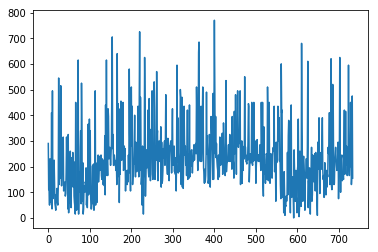

In [41]:
plt.plot(episode_returns)

In [42]:
import time

In [52]:
done = False
obj = env.reset()
rw = 0
while not done:
#     print('**********************************')
    act = act_net.forward(obj,max_act=True)
    time.sleep(0.02)
#     print(m.logits)
#     print(m.logits.argmax())
#     print(act)
    obj,reward,done,_ = env.step(act)
    rw += reward
    env.render()
env.close()
print(rw)

270.0


In [23]:
env.close()

In [40]:
act

0

In [43]:
m.logits

tensor([-1.6989, -1.7558, -2.4567, -0.5823], grad_fn=<SubBackward0>)

In [82]:
# torch.save(act_net,'ppo_cartpole')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ActorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
